### Description

Here, the data on individuals is used to construct couple-level variables.

### Packages

In [48]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

### Data Preparation

In [3]:
data_original = pd.read_csv("microdata.csv")

In [4]:
data = data_original[['gr_m_family_status']].copy()

In [5]:
data.loc[data['gr_m_family_status']!=2, 'gr_m_family_status']=1
data['gr_m_family_status'] = data['gr_m_family_status'] - 1

data['share_of_female_salary'] = [row['m_annual_salary_tm2'] / (1 + row['m_annual_salary_tm2'] + row['f_annual_salary_tm2'])
                                    if not np.isnan(row['m_annual_salary_tm2'])
                                        and not np.isnan(row['f_annual_salary_tm2'])
                                        and row['m_annual_salary_tm2'] != 0
                                        and row['f_annual_salary_tm2'] != 0
                                    else np.nan
                                    for i, row in data_original.iterrows()]

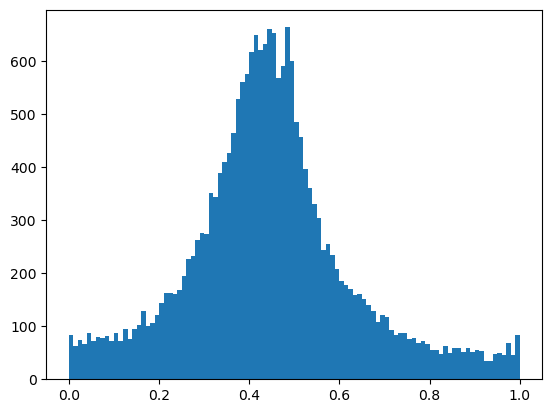

In [6]:
plt.hist(data['share_of_female_salary'], bins=100);

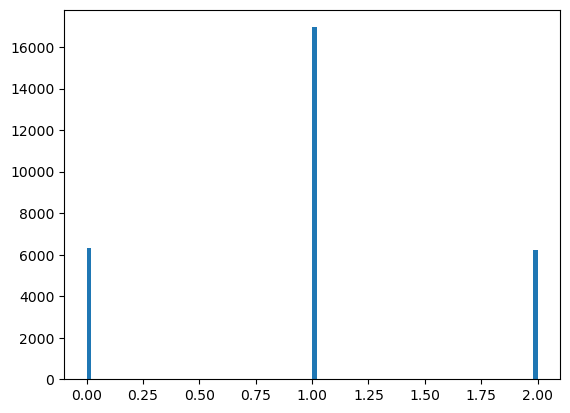

In [7]:
data['education_comparison'] = data_original['edu4_comp'].replace({0: 1, 1: 0, 2: 2})

# 0:  male education > female education, 1: equal, 2: male education < female education
plt.hist(data['education_comparison'], bins=100);

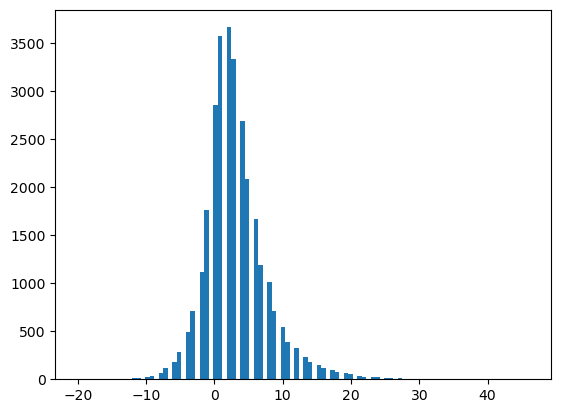

In [8]:
data['age_difference'] = data_original['f_age_at_birth'] - data_original['m_age_at_birth']

plt.hist(data['age_difference'], bins=100);

In [9]:
modified_data = data.copy()

In [10]:
model = bmb.Model('gr_m_family_status ~ age_difference + share_of_female_salary + education_comparison',
                    family='bernoulli',
                    data=modified_data.dropna())

In [11]:
# Assuming 'modified_data' is your DataFrame and it has been loaded previously
# Extracting the predictor variables and the outcome variable
age_difference = np.ma.array(data['age_difference'],
                                mask = np.isnan(data['age_difference']))
share_of_female_salary = np.ma.array(data['share_of_female_salary'],
                                mask = np.isnan(data['share_of_female_salary']))
education_comparison = np.ma.array(data['education_comparison'],
                                mask = np.isnan(data['education_comparison']))
gr_m_family_status = pd.Categorical(data['gr_m_family_status'])

education_comparison = pd.Categorical(data['education_comparison'],
                                        categories=range(2),
                                        ordered=True)

In [53]:
# Assuming 'modified_data' is your DataFrame and it has been loaded previously
# Extracting the predictor variables and the outcome variable
age_difference = data['age_difference'].copy()
share_of_female_salary = data['share_of_female_salary'].copy()
education_comparison = data['education_comparison'].copy()
gr_m_family_status = pd.Categorical(data['gr_m_family_status'] + 1)

education_comparison = pd.Categorical(data['education_comparison'],
                                        categories=range(2),
                                        ordered=True)

In [63]:
with pm.Model() as model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=1, sigma=10)
    beta_age = pm.Normal('beta_age', mu=1, sigma=10)
    beta_share = pm.Normal('beta_share', mu=1, sigma=10)

    # Priors for 'share_of_female_salary' and 'age_difference' as random variables
    share_of_fem_sal = pm.Normal('share_of_fem_sal',
                                    mu=0.5, 
                                    sigma=0.25,
                                    observed=data['share_of_female_salary'],
                                    shape=len(data['share_of_female_salary']))

    age_diff = pm.Normal('age_diff',
                            mu=5,
                            sigma=5,
                            observed=data['age_difference'],
                            shape=len(data['age_difference']))

    # Linear combination of predictors
    eta = intercept + age_diff * beta_age + share_of_fem_sal * beta_share

    #stabilized_eta = 
    # Link function and Bernoulli likelihood
    #p = pm.Deterministic('p', 1. / (1. + pt.exp(eta)))
    p = pm.math.logit(eta)
    outcome = pm.Bernoulli('outcome', p=p, observed=gr_m_family_status)
    
    # Sampling
    trace = pm.sample(1000,
                        step=pm.Metropolis(),
                        start=pm.find_MAP())

/opt/anaconda3/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in share_of_fem_sal contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/anaconda3/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in age_diff contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'intercept': array(1.), 'beta_age': array(1.), 'beta_share': array(1.), 'share_of_fem_sal_unobserved': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]), 'age_diff_unobserved': array([5., 5., 5., ..., 5., 5., 5.])}

Logp initial evaluation results:
{'intercept': -3.22, 'beta_age': -3.22, 'beta_share': -3.22, 'share_of_fem_sal_unobserved': 5266.17, 'age_diff_unobserved': -5527.03, 'share_of_fem_sal_observed': 3619.94, 'age_diff_observed': -90938.08, 'outcome': -inf}
You can call `model.debug()` for more details.

In [62]:
import pymc as pm
import numpy as np

# Assuming 'modified_data' is your DataFrame and it has been loaded previously
# Ensure 'education_comparison' is numerically encoded if it's categorical
education_comparison = modified_data['education_comparison'].astype(int).values
gr_m_family_status = modified_data['gr_m_family_status'].values

with pm.Model() as model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_share = pm.Normal('beta_share', mu=0, sigma=10)
    beta_education = pm.Normal('beta_education', mu=0, sigma=10)
    
    # Assuming you want to model these as normally distributed random variables
    # Adjust 'mu' and 'sd' based on your knowledge of their distributions
    age_difference_rv = pm.Normal('age_difference', mu=0, sigma=10, observed=modified_data['age_difference'])
    share_of_female_salary_rv = pm.Normal('share_of_female_salary', mu=0, sigma=1, observed=modified_data['share_of_female_salary'])
    
    # Linear combination of predictors, using random variables directly
    eta = intercept + beta_age * age_difference_rv + beta_share * share_of_female_salary_rv + beta_education * education_comparison
    
    # Probit link function via the standard normal CDF 'pm.math.phi'
    p = pm.math.phi(eta)
    
    # Bernoulli likelihood for binary outcome
    outcome = pm.Bernoulli('gr_m_family_status', p=p, observed=gr_m_family_status)
    
    # Sampling
    trace = pm.sample(1000, start=pm.find_MAP())

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [60]:
model.logp(model.test_value)

AttributeError: 'Model' object has no attribute 'test_value'

array([[<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>],
       [<Axes: title={'center': 'beta_education'}>,
        <Axes: title={'center': 'beta_education'}>],
       [<Axes: title={'center': 'beta_share'}>,
        <Axes: title={'center': 'beta_share'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

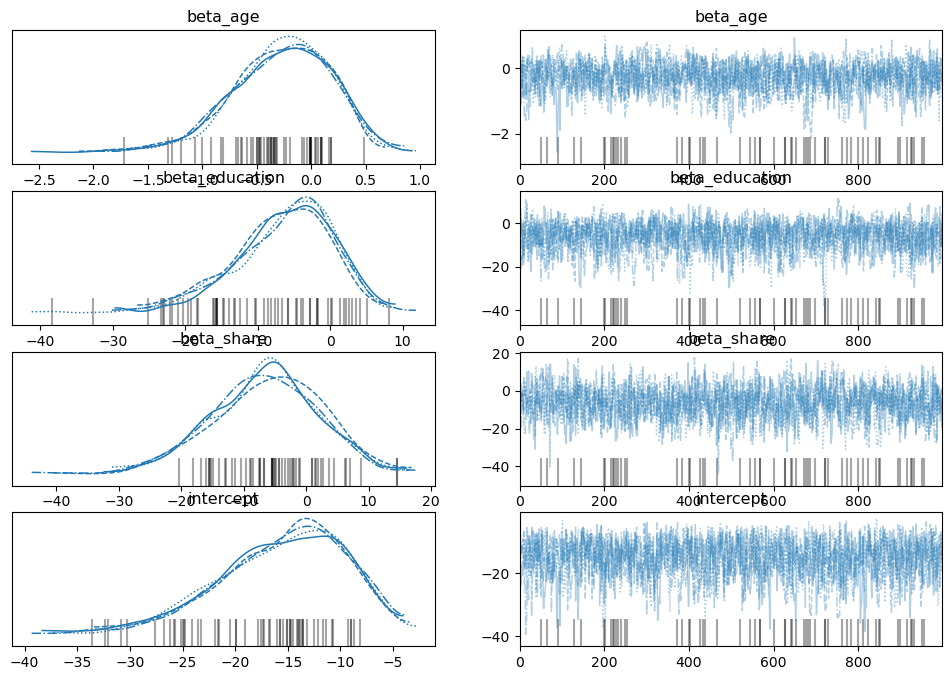

In [ ]:
az.plot_trace(trace)